<a href="https://colab.research.google.com/github/ohdayoung0/AI_Task/blob/main/week_05/pytorch_tts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.8.0+cu126
2.8.0+cu126
cuda


In [3]:
import IPython
import matplotlib.pyplot as plt

In [17]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hi! My name is Dayoung"
print(text_to_sequence(text))

[19, 20, 2, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11, 15, 12, 36, 26, 32, 25, 18]


In [19]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hi! My name is Dayoung"
processed, lengths = processor(text)

print(processed)
print(lengths)


tensor([[19, 20,  2, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11, 15, 12, 36,
         26, 32, 25, 18]])
tensor([22], dtype=torch.int32)


In [6]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


In [20]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hi! My name is Dayoung"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[54, 32,  2, 11, 66, 32, 11, 67, 48, 66, 11, 55, 94, 11, 38, 32, 93, 20,
         68]])
tensor([19], dtype=torch.int32)


In [29]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AY', '!', ' ', 'M', 'AY', ' ', 'N', 'EY', 'M', ' ', 'IH', 'Z', ' ', 'D', 'AY', 'Y', 'AH', 'NG']


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


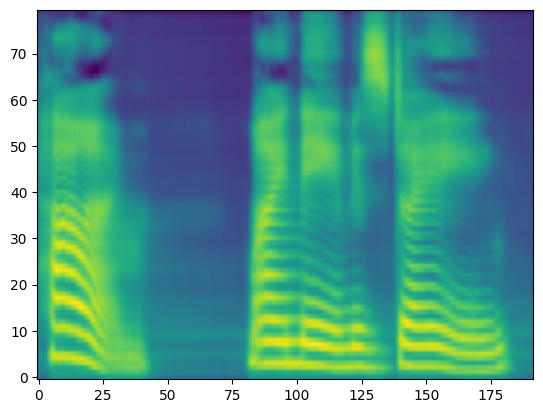

In [21]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hi! My name is Dayoung"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 132])
torch.Size([80, 153])
torch.Size([80, 145])


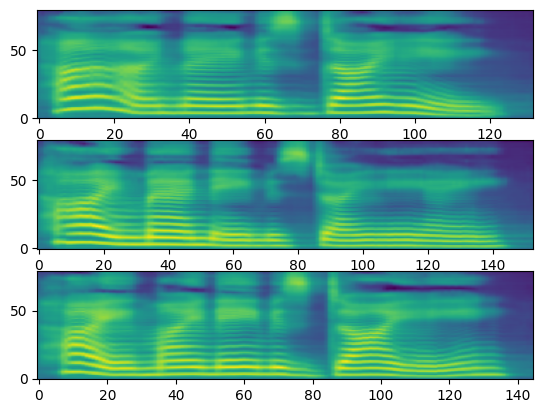

In [23]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

In [24]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hi! My name is Dayoung"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

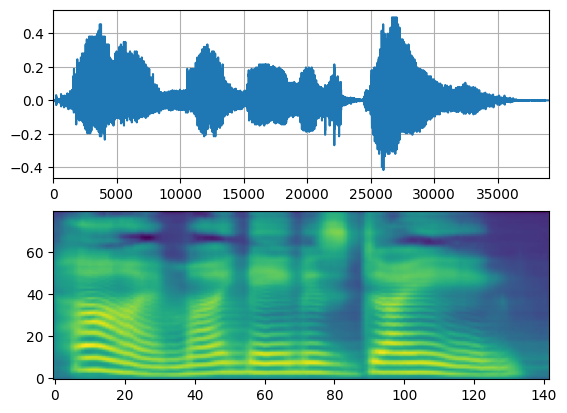

In [25]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)


In [26]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

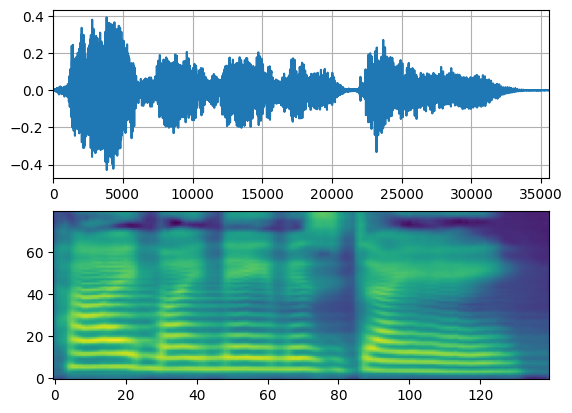

In [27]:
plot(waveforms, spec, vocoder.sample_rate)

In [28]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


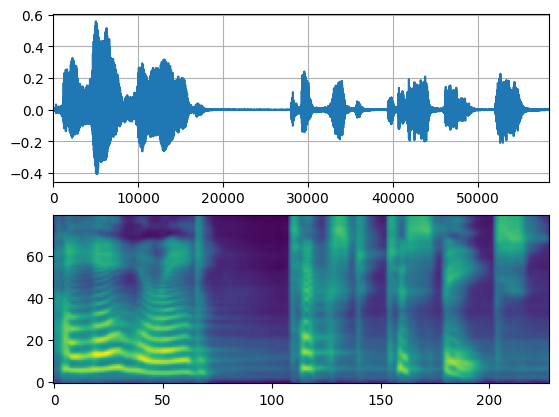

In [16]:
plot(waveforms, spec, 22050)